In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Se utiliza como dataset el texto *A Journey to the Center of the Earth* en inglés, del cual se extrae la parte principal delimitada por marcadores específicos. El texto se convierte a minúsculas y se genera un vocabulario de caracteres únicos. Luego se tokeniza en secuencias de longitud fija para crear conjuntos de entrenamiento y validación, donde cada secuencia se divide en entradas (X) y etiquetas (y) desplazadas un paso para entrenar modelos secuenciales.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
# abro el archivo y me guardo todas las líneas
with open('A_journey_to_the_Center_of_the_earth.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# busco dónde arranca y termina el texto útil
start_idx = next(i for i, line in enumerate(lines) if '*** START OF' in line)
#end_idx = next(i for i, line in enumerate(lines) if '*** END OF' in line)
end_idx = next(i for i, line in enumerate(lines) if 'But I thought it best not to urge this argument' in line)

# me quedo con las líneas del medio
main_text_lines = lines[start_idx + 1:end_idx]

# saco saltos de línea y uno todo en una sola string
main_text = ' '.join(line.strip() for line in main_text_lines)

# paso a minúsculas
article_text = main_text.lower()

In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

"    produced by norm wolcott      a journey to the centre of the earth  by jules verne     [redactor's note: journey to the centre of the earth is number v002 in the taves and michaluk numbering of the works of jules verne. first published in england by griffith and farran, 1871, this edition is not a translation at all but a complete re-write of the novel, with portions added and omitted, and names changed. the most reprinted version, it is entered into project gutenberg for reference purposes only. a better translation is _a journey into the interior of the earth_ translated by rev. f. a. malleson, also available on project gutenberg.]     table of contents  chapter 1 my uncle makes a great discovery  chapter 2 the mysterious parchment  chapter 3 an astounding discovery  chapter 4 we start on the journey  chapter 5 first lessons in climbing  chapter 6 our voyage to iceland  chapter 7 conversation and discovery  chapter 8 the eider-down hunter--off at last  chapter 9 our start--we me

### Tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = sorted(set(article_text))

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

52

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:1000]

[0,
 0,
 0,
 0,
 40,
 42,
 39,
 28,
 45,
 27,
 29,
 28,
 0,
 26,
 49,
 0,
 38,
 39,
 42,
 37,
 0,
 47,
 39,
 36,
 27,
 39,
 44,
 44,
 0,
 0,
 0,
 0,
 0,
 0,
 25,
 0,
 34,
 39,
 45,
 42,
 38,
 29,
 49,
 0,
 44,
 39,
 0,
 44,
 32,
 29,
 0,
 27,
 29,
 38,
 44,
 42,
 29,
 0,
 39,
 30,
 0,
 44,
 32,
 29,
 0,
 29,
 25,
 42,
 44,
 32,
 0,
 0,
 26,
 49,
 0,
 34,
 45,
 36,
 29,
 43,
 0,
 46,
 29,
 42,
 38,
 29,
 0,
 0,
 0,
 0,
 0,
 22,
 42,
 29,
 28,
 25,
 27,
 44,
 39,
 42,
 3,
 43,
 0,
 38,
 39,
 44,
 29,
 19,
 0,
 34,
 39,
 45,
 42,
 38,
 29,
 49,
 0,
 44,
 39,
 0,
 44,
 32,
 29,
 0,
 27,
 29,
 38,
 44,
 42,
 29,
 0,
 39,
 30,
 0,
 44,
 32,
 29,
 0,
 29,
 25,
 42,
 44,
 32,
 0,
 33,
 43,
 0,
 38,
 45,
 37,
 26,
 29,
 42,
 0,
 46,
 9,
 9,
 11,
 0,
 33,
 38,
 0,
 44,
 32,
 29,
 0,
 44,
 25,
 46,
 29,
 43,
 0,
 25,
 38,
 28,
 0,
 37,
 33,
 27,
 32,
 25,
 36,
 45,
 35,
 0,
 38,
 45,
 37,
 26,
 29,
 42,
 33,
 38,
 31,
 0,
 39,
 30,
 0,
 44,
 32,
 29,
 0,
 47,
 39,
 42,
 35,
 43,
 0,
 39,
 30,
 0,

### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array([seq[:-1] for seq in tokenized_sentences_train])
y = np.array([seq[1:] for seq in tokenized_sentences_train])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(206268, 99)

In [18]:
X[0,:10]

array([ 0,  0,  0,  0, 40, 42, 39, 28, 45, 27])

In [19]:
y[0,:10]

array([ 0,  0,  0, 40, 42, 39, 28, 45, 27, 29])

In [20]:
vocab_size = len(chars_vocab)

### Definiendo los modelos

In [21]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, GRU, Dense
from keras.models import Model, Sequential

### Modelos secuenciales con embeddings y capas recurrentes

Se implementaron tres modelos secuenciales para modelado de lenguaje a nivel carácter. Cada uno comienza con una capa de **embedding** entrenable que transforma los índices de caracteres en vectores densos. Luego se utiliza una **capa recurrente** con 200 unidades, en variantes `SimpleRNN`, `LSTM` o `GRU`, seguida de una capa **densa con softmax** que predice la distribución de probabilidad del siguiente carácter en cada paso.

Todos los modelos se entrenan con `sparse_categorical_crossentropy` y el optimizador `rmsprop`, permitiendo evaluar el desempeño de diferentes arquitecturas recurrentes bajo condiciones comparables.

In [22]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None))  
model_rnn.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_rnn.add(Dense(vocab_size, activation='softmax'))
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [23]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None))  
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [24]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=None)) 
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

En el siguiente callback se calcula la **perplejidad** sobre el conjunto de validación al final de cada época. Además, se incorpora un mecanismo de **early stopping** que detiene el entrenamiento si la perplejidad no mejora tras un número dado de épocas.

In [25]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=3):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      
      self.model_name = model_name
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [26]:
# No entreno nuevamente los modelos, ya que ya están entrenados y guardados.

# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
#history_ppl_rnn = []
#hist_rnn = model_rnn.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_rnn,model_name="model_rnn.keras")], batch_size=256)

#history_ppl_lstm = []
#hist_lstm = model_lstm.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_lstm,model_name="model_lstm.keras")], batch_size=256)

#history_ppl_gru = []
#hist_gru = model_gru.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_gru,model_name="model_gru.keras")], batch_size=256)

In [27]:
import numpy as np

#np.save("history_ppl_rnn.npy", np.array(history_ppl_rnn))
#np.save("history_ppl_lstm.npy", np.array(history_ppl_lstm))
#np.save("history_ppl_gru.npy", np.array(history_ppl_gru))

# Para cargar los historiales de perplejidad
history_ppl_rnn = np.load("history_ppl_rnn.npy").tolist()
history_ppl_lstm = np.load("history_ppl_lstm.npy").tolist()
history_ppl_gru = np.load("history_ppl_gru.npy").tolist()



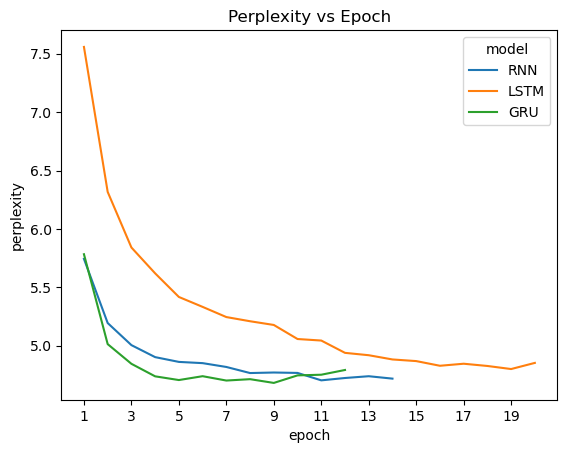

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame([
    {"epoch": i, "perplexity": val, "model": m}
    for m, history in zip(["RNN","LSTM","GRU"], [history_ppl_rnn, history_ppl_lstm, history_ppl_gru])
    for i, val in enumerate(history, 1)
])

sns.lineplot(data=df, x="epoch", y="perplexity", hue="model")
plt.title("Perplexity vs Epoch")
plt.xticks(range(1, df["epoch"].max() + 1, 2))
plt.savefig("perplexity_vs_epoch.png")
plt.show()

![Perplexity vs Epoch](perplexity_vs_epoch.png)

Todos los modelos reducen la perplejidad durante el entrenamiento y se detienen automáticamente cuando no hay mejora tras varias épocas (early stopping con `patience = 3` en este caso).

El **RNN** muestra una caída progresiva de la perplejidad hasta alcanzar **4.7035** en la **época 11**, donde registra su mínimo. A partir de ahí, las variaciones son menores y se mantiene estable entre **4.7 y 4.8**.

El **LSTM** comienza con valores más altos, pero mejora de forma sostenida a lo largo de todo el entrenamiento. Su perplejidad baja hasta **4.8003** en la **época 19**, que es su mejor valor antes de que vuelva a subir levemente.

El **GRU** desciende rápidamente, llegando a **4.7060** ya en la **época 5**, pero luego muestra más variabilidad. Aunque mantiene valores similares, no logra una estabilización tan clara como los otros modelos.

En resumen, **RNN y LSTM** muestran mayor estabilidad hacia el final, mientras que el **GRU** tiene un mejor desempeño inicial pero con más fluctuaciones posteriores.

In [29]:
# Cargo los modelos guardados del entrenamiento para hacer inferencia
model_rnn = keras.models.load_model('model_rnn.keras')
model_lstm = keras.models.load_model('model_lstm.keras')
model_gru = keras.models.load_model('model_gru.keras')

### Generación de secuencias

In [30]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [31]:
input_text='I was far more willing to allow that this chimney of'

generate_seq(model_rnn, input_text, max_length=max_context_size, n_words=100)

'I was far more willing to allow that this chimney of the sound of the sound of the sound of the sound of the sound of the sound of the sound of the soun'

In [32]:
generate_seq(model_lstm, input_text, max_length=max_context_size, n_words=100)

'I was far more willing to allow that this chimney of the secret of the secret of the secret of the secret of the secret of the secret of the secret of t'

In [33]:
generate_seq(model_gru, input_text, max_length=max_context_size, n_words=100)

'I was far more willing to allow that this chimney of the earth.  "well, the sun professor hardwigg, which we were about the most considerable professor '

### Predicciones de modelos (generación con greedy search)

Partiendo del mismo texto inicial  
**“I was far more willing to allow that this chimney of”**  
cada modelo de PLN genera una continuación distinta, según su arquitectura.

El modelo **RNN** repite en bucle:  
**"the sound of the sound of the sound of..."**  
Esto muestra que tiene problemas para mantener coherencia cuando el texto se alarga.

El **LSTM** mejora un poco, pero también repite:  
**"the secret of the secret of the secret of..."**  
Tiene más memoria que el RNN, pero todavía cae en repeticiones.

El **GRU** da un texto más variado y con más sentido:  
**"the earth. 'Well, the sun professor Hardwigg, which we were about the most considerable professor"**  
Esto indica que maneja mejor el contexto y puede generar continuaciones más coherentes y variadas.

###  Beam search y muestreo aleatorio

In [34]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):
    text = text.lower() 
    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [35]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

## Análisis de generación con GRU

Se evaluó el impacto de los parámetros `beam size` y `temperature` en la generación de texto usando únicamente el modelo **GRU**, seleccionado por su mejor desempeño en búsqueda greedy.

Primero se varió el `beam size` con temperatura fija, y luego la `temperature` con `beam size` fijo, analizando cómo afectan la coherencia y diversidad del texto generado.

In [36]:
input_text = "I was far more willing to allow that this chimney of"
input_text = input_text.lower()
num_words = 100

beam_values = [3, 5, 10, 20]
temperature_values = [0.1, 1.0, 2.0, 10, 100]

model = model_gru
model_name = "GRU"
results = []

fixed_temp = 1.0
for beams in beam_values:
    encoded_input = encode(input_text)
    tokens = beam_search(model, num_beams=beams, num_words=num_words, input=input_text, temp=fixed_temp, mode='sto')
    generated_text = decode(tokens[0])
    results.append({
        "model": model_name,
        "beams": beams,
        "temperature": fixed_temp,
        "text": generated_text
    })
    print(f"Beams: {beams} | Temp: {fixed_temp}")
    print(generated_text)
    print("-" * 80)

fixed_beam = 5
for temp in temperature_values:
    encoded_input = encode(input_text)
    tokens = beam_search(model, num_beams=fixed_beam, num_words=num_words, input=input_text, temp=temp, mode='sto')
    generated_text = decode(tokens[0])
    results.append({
        "model": model_name,
        "beams": fixed_beam,
        "temperature": temp,
        "text": generated_text
    })
    print(f"Beams: {fixed_beam} | Temp: {temp}")
    print(generated_text)
    print("-" * 80)

Beams: 3 | Temp: 1.0
i was far more willing to allow that this chimney of the bottom of parchment, which is the great and some manuscripts of duty of its nest, however, with
--------------------------------------------------------------------------------
Beams: 5 | Temp: 1.0
i was far more willing to allow that this chimney of the matter of the crater of the earth."  "well, and at all events, and yet him to the time is into 
--------------------------------------------------------------------------------
Beams: 10 | Temp: 1.0
i was far more willing to allow that this chimney of the matter," he said my uncle, which was about the earth.  the professor hardwigg, and then the sli
--------------------------------------------------------------------------------
Beams: 20 | Temp: 1.0
i was far more willing to allow that this chimney of the earth."  "well," cried my uncle, which were there was nothing of the earth, and therefore, and 
-----------------------------------------------------------

## Conclusión

- Se utilizó como corpus la novela *A Journey to the Center of the Earth*. El texto fue preprocesado usando una ventana de contexto de 100 caracteres y tokenizado a partir de los caracteres únicos presentes.

- Se entrenaron tres modelos: RNN, LSTM y GRU. Cada uno incluye una capa `Embedding`, una capa recurrente con 200 unidades (SimpleRNN, LSTM o GRU), y una capa `Dense` con activación `softmax`. Se usó `sparse_categorical_crossentropy` como función de pérdida y `rmsprop` como optimizador.

- El entrenamiento se realizó con early stopping con `patience` igual a 3, monitoreando la perplexidad.

- Para comparar los modelos, se predijo una secuencia de 100 caracteres a partir del mismo texto de entrada:  
  **"I was far more willing to allow that this chimney of"** (convertido a minúsculas).

- En esta comparación, el modelo GRU generó texto más coherente y variado, mientras que RNN y LSTM repitieron secuencias sin sentido. Por este motivo, se seleccionó GRU para el análisis posterior.

- Se evaluó la generación de texto con GRU utilizando **beam search estocástico**, variando dos hiperparámetros clave:
  - `beam size`: [3, 5, 10, 20]
  - `temperature`: [0.1, 1.0, 2.0, 10, 100]

- Primero se varió el tamaño del haz con temperatura fija, y luego la temperatura con `beam size` fijo, con el objetivo de analizar cómo afectan estos parámetros la coherencia y diversidad del texto generado. A mayor `beam size` el texto ganó coherencia. Al variar la temperatura con `beam size` fijo, temperaturas bajas produjeron texto menos expresivo (con algo de repetitividad) y conservador, temperaturas medias generaron texto más fluido y diverso, y temperaturas muy altas resultaron en texto incoherente y sin sentido. Esto indica que un `beam size` moderado junto a una temperatura baja o media es ideal para generar texto coherente y variado con el modelo GRU.
